# Benchmark SGD Implementations  
In this iPython notebook, we benchmark the Parallel implementaton of SGD against the implementation in SciKit-Learn library. We will use SGD in both cases for regression on synthetic data.   

**Credits**  
1. The parallel implementation here is based on this paper: Zinkevich, M., Weimer, M., Li, L., & Smola, A. (2010). Parallelized stochastic gradient descent. Advances in Neural Information Processing Systems, 1–36. Retrieved from http://papers.nips.cc/paper/4006-parallelized-stochastic-gradient-descent 
2. Niu, F., Recht, B., Re, C., & Wright, S. J. (2011). HOGWILD!: A Lock-Free Approach to Parallelizing Stochastic Gradient Descent. Advances in Neural Information Processing Systems, (1), 21. Retrieved from http://arxiv.org/abs/1106.5730 

## The Dataset  
The dataset will be generated using SciKit-Learn's `make_regression` function.  

In [10]:
from sklearn.datasets import make_regression
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import time

In [3]:
n_samples = 1000
n_features = 100
seed = 1
effective_rank = 100

In [4]:
X, y = make_regression(n_samples=n_samples, n_features=n_features, 
                       random_state=seed, noise=0.0, 
                       effective_rank=effective_rank)

Split the dataset into train and test

In [5]:
from sklearn.cross_validation import ShuffleSplit

In [6]:
for train, test in ShuffleSplit(n=n_samples, n_iter=1, test_size=0.2):
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]

## SciKit-Learn SGD

In [11]:
from sklearn.linear_model import SGDRegressor

In [12]:
n_iter = 5000

In [ ]:
sgd = SGDRegressor(n_iter=n_iter, warm_start=True, eta0=0.01)

start_time = time.time()
sgd.fit(X_train, y_train)
time1 = time.time() - start_time

In [17]:
print "Baseline time: %0.2f seconds" % time1

Baseline time: 1.16 seconds


In [18]:
score1 = sgd.score(X_test, y_test)
print "Baseline score: %0.2f" % score1

Baseline score: 0.74


## Parallel SGD
Parallel implementation of SGD based on the simulation results from previous section

In [ ]:
from multiprocessing import Pool
import utils
import time
import math

In [21]:
import utils
from joblib import Parallel, delayed

### PSDG1 Performance
Parallel SGD with reduced iterations per worker and one sync at the end. Iterations are split evenly amongst all workers

In [23]:
speedup_acc = []

for n_jobs in range(1, 5):
    n_iter_per_job = n_iter/n_jobs
    start_time = time.time()
    sgd = utils.psgd_1(SGDRegressor(), n_iter_per_job, n_jobs, X_train, y_train)
    elapsed_time = time.time() - start_time
    speedup_acc += [[time1/elapsed_time, sgd.score(X_test, y_test)]]

speedup_acc = np.array(speedup_acc).T

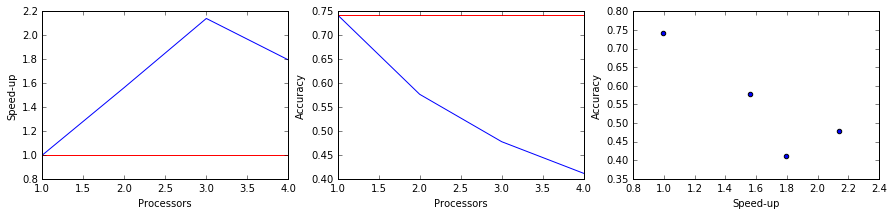

In [24]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.plot(range(1,5), speedup_acc[0])
plt.axhline(1, c='r')
plt.xlabel("Processors")
plt.ylabel("Speed-up")

plt.subplot(1, 3, 2)
plt.plot(range(1,5), speedup_acc[1])
plt.axhline(y=score1, c='r')
plt.xlabel("Processors")
plt.ylabel("Accuracy")

plt.subplot(1, 3, 3)
plt.scatter(speedup_acc[0], speedup_acc[1])
plt.xlabel("Speed-up")
plt.ylabel("Accuracy")

### PSG2 Performance
Parallel SGD with reduced iterations per worker and multiple syncs throughout the iterations. Iterations are split evenly amongst all workers. There are as many syncs as there are workers.

In [36]:
speedup_acc = []

for n_jobs in range(1, 5):
    n_iter_per_job = n_iter/n_jobs
    start_time = time.time()
    sgd = utils.psgd_2(SGDRegressor(), n_iter_per_job, n_jobs, 10, X_train, y_train)
    elapsed_time = time.time() - start_time
    speedup_acc += [[time1/elapsed_time, sgd.score(X_test, y_test)]]

speedup_acc = np.array(speedup_acc).T

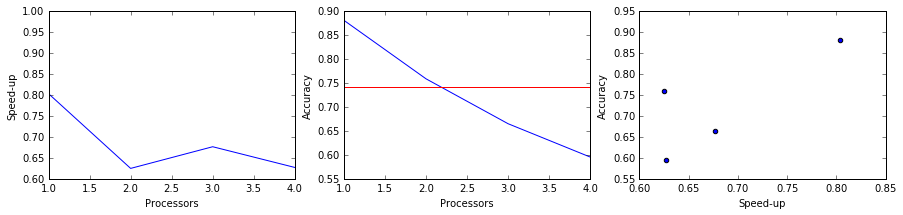

In [37]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.plot(range(1,5), speedup_acc[0])
plt.axhline(1, c='r')
plt.xlabel("Processors")
plt.ylabel("Speed-up")

plt.subplot(1, 3, 2)
plt.plot(range(1,5), speedup_acc[1])
plt.axhline(y=score1, c='r')
plt.xlabel("Processors")
plt.ylabel("Accuracy")

plt.subplot(1, 3, 3)
plt.scatter(speedup_acc[0], speedup_acc[1])
plt.xlabel("Speed-up")
plt.ylabel("Accuracy")

### PSG3 Performance
Parallel SGD with reduced iterations per worker, multiple syncs, and increased learning rate per worker. Iterations are split evenly amongst all workers. There are as many syncs as there are workers. The learning rate is increased by a factor of the number of workers.

In [38]:
reload(utils)

<module 'utils' from 'utils.pyc'>

In [49]:
speedup_acc = []

for n_jobs in range(1, 5):
    n_iter_per_job = n_iter/n_jobs
    start_time = time.time()
    sgd = utils.psgd_3(SGDRegressor(), n_iter_per_job, n_jobs, 10, X_train, y_train)
    elapsed_time = time.time() - start_time
    speedup_acc += [[time1/elapsed_time, sgd.score(X_test, y_test)]]

speedup_acc = np.array(speedup_acc).T

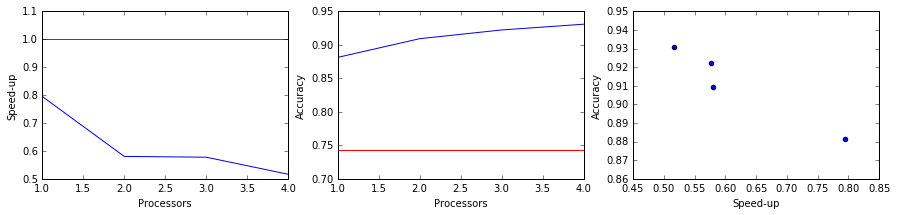

In [50]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.plot(range(1,5), speedup_acc[0])
plt.axhline(1, c='r')
plt.xlabel("Processors")
plt.ylabel("Speed-up")

plt.subplot(1, 3, 2)
plt.plot(range(1,5), speedup_acc[1])
plt.axhline(y=score1, c='r')
plt.xlabel("Processors")
plt.ylabel("Accuracy")

plt.subplot(1, 3, 3)
plt.scatter(speedup_acc[0], speedup_acc[1])
plt.xlabel("Speed-up")
plt.ylabel("Accuracy")

### PSG4 Performance
Parallel SGD with reduced iterations per worker and shared weights. This is implemented using threading and shared memory. Iterations are split evenly amongst all workers. Each worker reads the weights from a shared memory, processes them, and overwrites it. 

In [51]:
reload(utils)

<module 'utils' from 'utils.py'>

In [53]:
speedup_acc = []

for n_jobs in range(1, 5):
    n_iter_per_job = n_iter/n_jobs
    coef = np.random.sample(size=(X_train.shape[1],))
    intercept = np.random.sample(size=(1,))
    start_time = time.time()
    sgd = utils.psgd_4(SGDRegressor(), 
                       n_iter_per_job, n_jobs, 
                       X_train, y_train, 
                       coef, intercept)
    elapsed_time = time.time() - start_time
    speedup_acc += [[time1/elapsed_time, sgd.score(X_test, y_test)]]

speedup_acc = np.array(speedup_acc).T

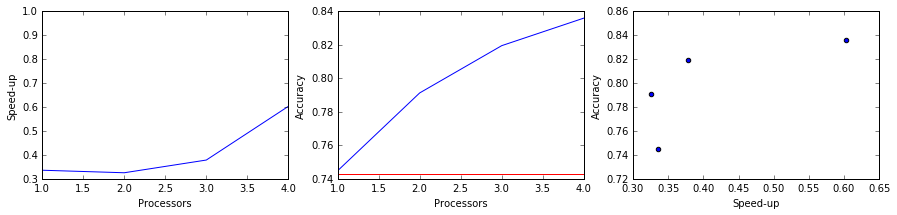

In [54]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.plot(range(1,5), speedup_acc[0])
plt.axhline(1, c='r')
plt.xlabel("Processors")
plt.ylabel("Speed-up")

plt.subplot(1, 3, 2)
plt.plot(range(1,5), speedup_acc[1])
plt.axhline(y=score1, c='r')
plt.xlabel("Processors")
plt.ylabel("Accuracy")

plt.subplot(1, 3, 3)
plt.scatter(speedup_acc[0], speedup_acc[1])
plt.xlabel("Speed-up")
plt.ylabel("Accuracy")